In [60]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import umap.plot

import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go

import seaborn as sns
from statannotations.Annotator import Annotator
import warnings

In [76]:
import os 
root_dir_model = "/Users/rdijk/Desktop/FULL_BACKUP/backup_feature_aggregation/ProjectFA/Phase1/FinalModelResults"
root_dir_bm = "/Users/rdijk/Desktop/FULL_BACKUP/backup_feature_aggregation/ProjectFA/Phase1/Benchmarks"

## MOA prediction

In [77]:
merge_datasets = True

datasets = ['Stain2', 'Stain3', 'Stain4', 'Stain5']
stratifications = ['training', 'validation', 'test']
bigDF = []
for key in datasets:
    df = pd.read_csv(os.path.join(root_dir_model, f'mAP/{key}/FinalModelResults_{key}.csv'))
    # Remove BM columns and append to bottom of DF
    BMmap = pd.DataFrame(df.loc[:, ['plate', 'mAP BM']]).rename(columns={'mAP BM': 'mAP model'})
    df.drop('mAP BM', axis=1, inplace=True)
    df = pd.concat([df, BMmap])
    # Add dataset columns
    if merge_datasets:
        if key == 'Stain5':
            df['dataset'] = ["out-of-distribution\nStain5"]*len(df)
        else:
            df['dataset'] = ['Stain2-4']*len(df)
    else:
        df['dataset'] = [key]*len(df)
    # Add method columns
    df['method'] = ['CytoSummaryNet']*(len(df)//2) + ['average profiling']*(len(df)//2)
    # Add platelabels
    platelabels = pd.read_csv(os.path.join(root_dir_bm, f'platelabels{key}.csv'))
    df = df.merge(platelabels, on='plate')
    bigDF.append(df)
bigDF = pd.concat(bigDF)

if merge_datasets:
    stratY = 2
    datasets = ['Stain2-4', 'out-of-distribution\nStain5']
else:
    stratY = 4

In [78]:
print(bigDF.shape)
bigDF

(84, 11)


,plate,mAP model,dataset,method,platelabel,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7
0,BR00112202,0.178249,Stain2-4,CytoSummaryNet,training,NaN,NaN,NaN,NaN,NaN,NaN
1,BR00112202,0.098738,Stain2-4,average profiling,training,NaN,NaN,NaN,NaN,NaN,NaN
2,BR00112197standard,0.168084,Stain2-4,CytoSummaryNet,validation,NaN,NaN,NaN,NaN,NaN,NaN
3,BR00112197standard,0.098116,Stain2-4,average profiling,validation,NaN,NaN,NaN,NaN,NaN,NaN
4,BR00112199,0.106735,Stain2-4,CytoSummaryNet,test,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
5,BR00120532,0.121583,out-of-distribution\nStain5,average profiling,test,NaN,NaN,NaN,NaN,NaN,NaN
6,BR00120536,0.029385,out-of-distribution\nStain5,CytoSummaryNet,test,NaN,NaN,NaN,NaN,NaN,NaN
7,BR00120536,0.122782,out-of-distribution\nStain5,average profiling,test,NaN,NaN,NaN,NaN,NaN,NaN
8,BR00120526,0.133091,out-of-distribution\nStain5,CytoSummaryNet,test,NaN,NaN,NaN,NaN,NaN,NaN


In [79]:
merge_datasets = True

datasets = ['Stain2', 'Stain3', 'Stain4', 'Stain5']
stratifications = ['training', 'validation', 'test']
bigDF = []
for key in datasets:
    df = pd.read_csv(os.path.join(root_dir_model, f'mAP/{key}/FinalModelResults_{key}.csv'))
    # Remove BM columns and append to bottom of DF
    BMmap = pd.DataFrame(df.loc[:, ['plate', 'mAP BM']]).rename(columns={'mAP BM': 'mAP model'})
    df.drop('mAP BM', axis=1, inplace=True)
    df = pd.concat([df, BMmap])
    df['method'] = ['CytoSummaryNet']*(len(df)//2) + ['average profiling']*(len(df)//2)
    # Add platelabels
    platelabels = pd.read_csv(os.path.join(root_dir_bm, f'platelabels{key}.csv'))
    df = df.merge(platelabels, on='plate')

    # Add dataset columns
    if merge_datasets:
        if key == 'Stain5':
            df['dataset'] = ["out-of-distribution plates\nStain5"]*len(df)
        else:
            dataset_mapping = {
                'training':'training plates\nStain2-4',
                'validation': 'validation plates\nStain2-4',
                'test': 'test plates\nStain2-4'
            }
            df['dataset'] = df['platelabel'].map(dataset_mapping)
    else:
        df['dataset'] = [key]*len(df)
    # Add method columns




    bigDF.append(df)
bigDF = pd.concat(bigDF)

if merge_datasets:
    stratY = 4
    datasets = ['training plates\nStain2-4', 'validation plates\nStain2-4', 'test plates\nStain2-4', 'out-of-distribution plates\nStain5']
else:
    stratY = 4

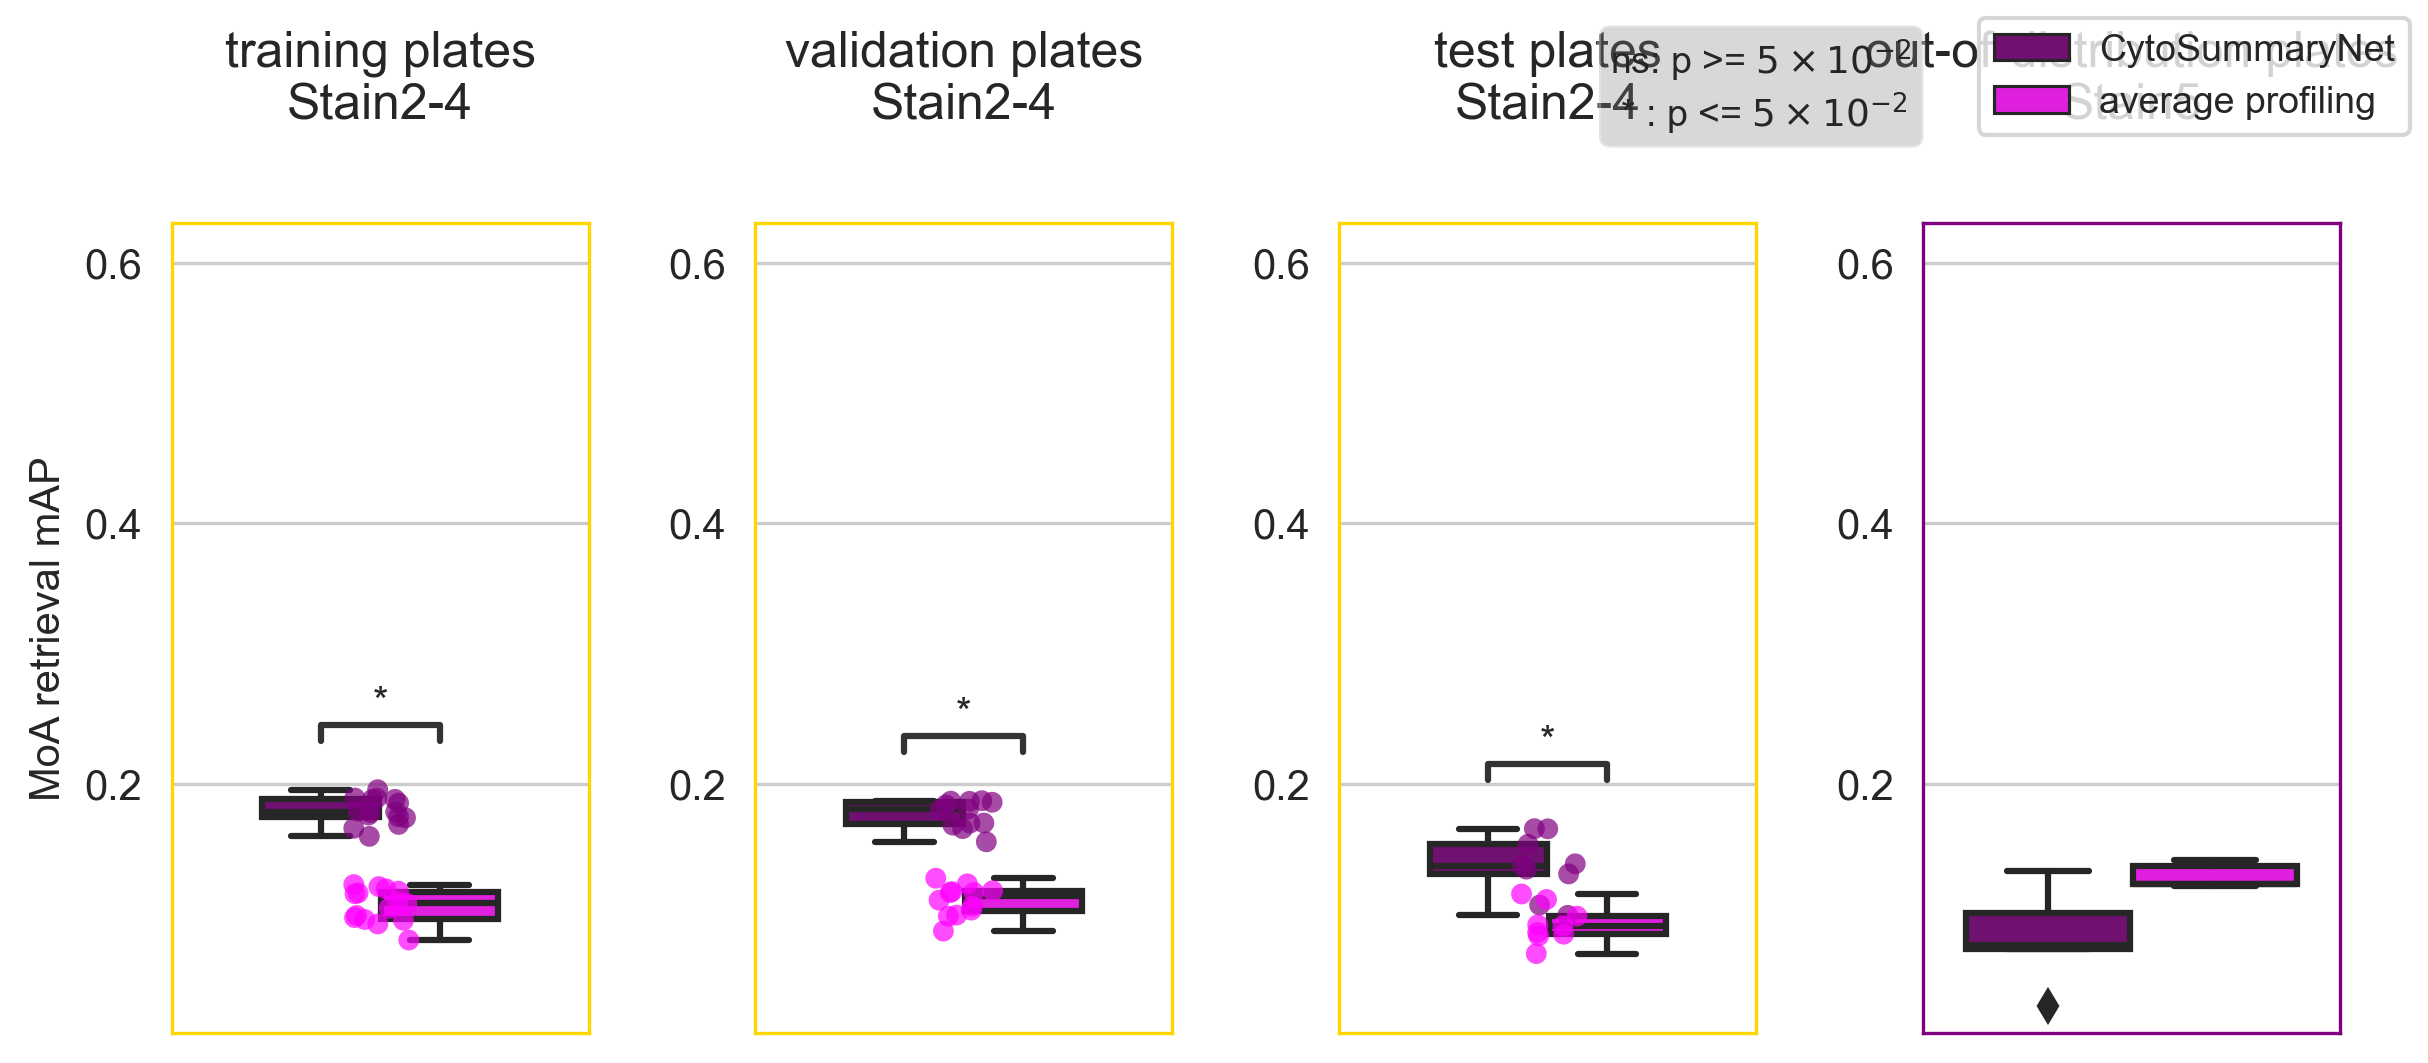

In [80]:
sns.set_style("whitegrid")

x = "dataset"
y = "mAP model"
hue = "method"
display_method = 'star' # star full simple

my_pal = {"CytoSummaryNet":"purple", "average profiling": 'magenta'}


fig, ax = plt.subplots(1, stratY, dpi=300, figsize=(8, 3))
# First loop over different datasets 
for dataset_idx in range(stratY):
    cdataset = datasets[dataset_idx]
    subDF = bigDF.loc[bigDF['dataset'] == cdataset]
    # Then over different stratifications 
    subsubDF = subDF.copy()

    if dataset_idx==stratY-1:
        fakeax = sns.boxplot(data=subsubDF, x=x, y=y, hue=hue, ax=ax[dataset_idx], palette=my_pal)
        fakeax.legend([],[], frameon=False)
        fakeax.set(ylabel=None)
        fakeax.set(xticklabels=[])
        fakeax.set(xlabel=None)
        
        fakeax.set_ylim(min_y, max_y)
        fakeax.yaxis.set_major_locator(plt.MaxNLocator(4))
        continue
    
    with sns.plotting_context("notebook", font_scale = 0.8):
        subax = sns.boxplot(data=subsubDF, x=x, y=y, hue=hue, ax=ax[dataset_idx], palette=my_pal)
        sns.stripplot(data=subsubDF, x=x, y=y, hue=hue, ax=ax[dataset_idx], alpha=0.7, palette=my_pal)
        box_pairs=[((cdataset, 'CytoSummaryNet'), (cdataset, 'average profiling'))]
        
        
        subax.set_ylim(min_y, max_y)

        
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            annotator = Annotator(subax, pairs=box_pairs, data=subsubDF, x=x, y=y, hue=hue)
            annotator.configure(test='t-test_welch', text_format=display_method, 
                                loc='inside', test_short_name='t-test welch', verbose=False)
            annotator.apply_and_annotate()

        # remove all the labels and ticks 
        subax.set(xticklabels=[])
        subax.set(xlabel=None)
        subax.tick_params(bottom=False)
        if dataset_idx != 0:
            subax.set(ylabel=None)
        else:
            subax.set(ylabel="MoA retrieval mAP")

        subax.legend([],[], frameon=False)
        subax.yaxis.set_major_locator(plt.MaxNLocator(4))
        

plt.tight_layout()
fig.subplots_adjust(hspace=0.1, wspace=0.4)

handles, labels = fakeax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right', fontsize=9)


textstring = r'ns: p >= $5\times10^{-2}$'+'\n'+r' * : p <= $5\times10^{-2}$'
#+'\n**: $10^{-3}$ < p <= $10^{-2}$\n***: $10^{-4}$ < p <= $10^{-3}$\n****: p <= $10^{-4}$
props = dict(boxstyle='round', facecolor='grey', alpha=0.3)
fig.text(0.65, 1.23, textstring,
         fontsize=9, transform=subax.transAxes,
        verticalalignment='top', bbox=props)

# Set colours
for a in ax.flat[:3]:
    for spine in a.spines.values():
        spine.set_edgecolor('gold')
for spine in ax.flat[-1].spines.values():
    spine.set_edgecolor('purple')


titles = ['training plates\nStain2-4', 'validation plates\nStain2-4', 'test plates\nStain2-4', 'out-of-distribution plates\nStain5']


for a, title in zip(ax.flat, titles):
    a.set_title(title, pad=25)

# Get the minimum and maximum y-axis values across all subplots
min_y = min(a.get_ylim()[0] for a in ax.flatten())
max_y = max(a.get_ylim()[1] for a in ax.flatten())

if not merge_datasets:
    plt.savefig(os.path.join(root_dir_model, 'MOAmAP.png'), bbox_inches='tight')
else:
    plt.savefig(os.path.join(root_dir_model, 'MOAmAP_merged.png'), bbox_inches='tight')



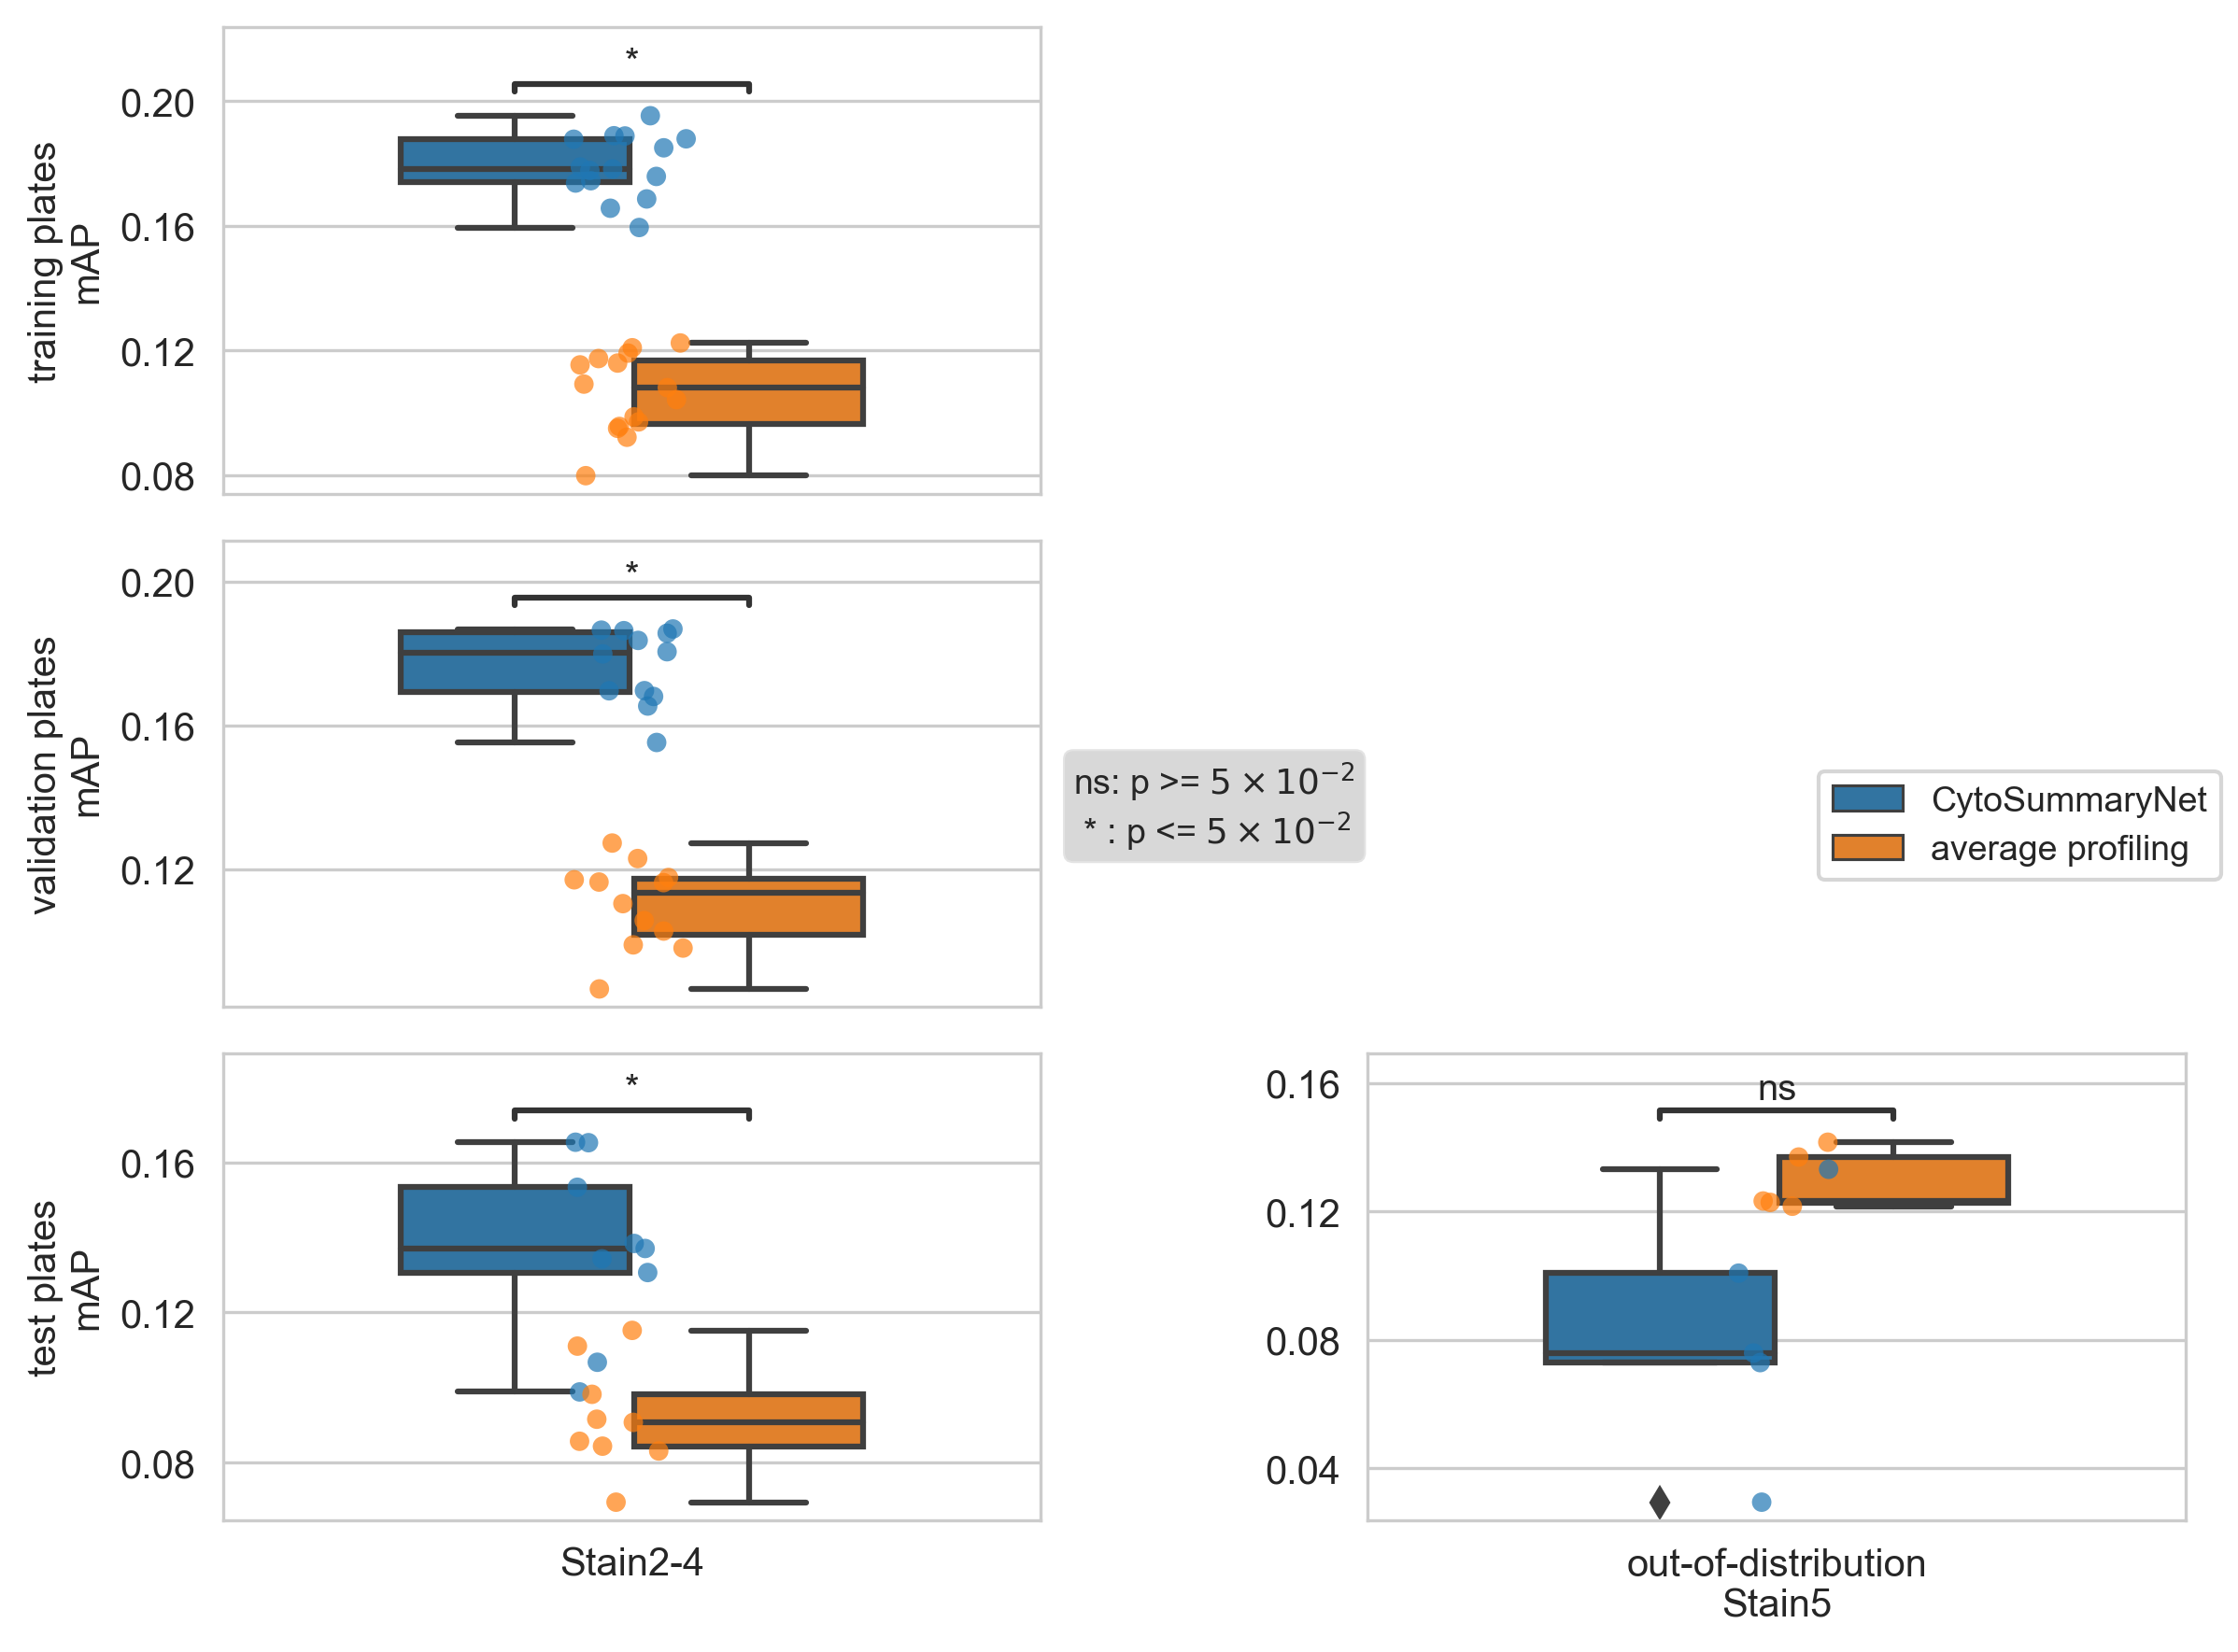

In [224]:
sns.set_style("whitegrid")

x = "dataset"
y = "mAP model"
hue = "method"
display_method = 'star' # star full simple

fig, ax = plt.subplots(3, stratY, dpi=300, figsize=(8, 6))
# First loop over different datasets 
for dataset_idx in range(stratY):
    cdataset = datasets[dataset_idx]
    subDF = bigDF.loc[bigDF['dataset'] == cdataset]
    # Then over different stratifications 
    for strat_idx in range(3):
        if dataset_idx==stratY-1 and strat_idx<2:
            fakeax = sns.boxplot(data=subsubDF, x=x, y=y, hue=hue, ax=ax[strat_idx, dataset_idx])
            continue
        subsubDF = subDF.loc[subDF['platelabel'] == stratifications[strat_idx]]
        #print(np.mean(np.array(subsubDF['mAP model'][subsubDF.method == 'model']-np.array(subsubDF['mAP model'][subsubDF.method == 'baseline'])))/np.mean(subsubDF['mAP model'][subsubDF.method == 'baseline']))
        #print(subsubDF)
        with sns.plotting_context("notebook", font_scale = 0.8):
            subax = sns.boxplot(data=subsubDF, x=x, y=y, hue=hue, ax=ax[strat_idx, dataset_idx])
            sns.stripplot(data=subsubDF, x=x, y=y, hue=hue, ax=ax[strat_idx, dataset_idx], alpha=0.7)
            box_pairs=[((cdataset, 'CytoSummaryNet'), (cdataset, 'average profiling'))]

            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                annotator = Annotator(subax, pairs=box_pairs, data=subsubDF, x=x, y=y, hue=hue)
                annotator.configure(test='t-test_welch', text_format=display_method, 
                                    loc='inside', test_short_name='t-test welch', verbose=False)
                annotator.apply_and_annotate()

            # remove all the labels and ticks 
            if strat_idx != 2:
                subax.set(xticklabels=[])
            subax.set(xlabel=None)
            subax.tick_params(bottom=False)
            if dataset_idx != 0:
                subax.set(ylabel=None)
            else:
                if strat_idx==0:
                    subax.set(ylabel='training plates\nmAP')
                elif strat_idx==1:
                    subax.set(ylabel='validation plates\nmAP')
                else:
                    subax.set(ylabel='test plates\nmAP')
            subax.legend([],[], frameon=False)
            subax.yaxis.set_major_locator(plt.MaxNLocator(4))

plt.tight_layout()
fig.subplots_adjust(hspace=0.1, wspace=0.4)

handles, labels = fakeax.get_legend_handles_labels()
fig.legend(handles, labels, loc='right', fontsize=9)

if not merge_datasets:
    fig.delaxes(ax[0][3])
    fig.delaxes(ax[1][3])
else:
    fig.delaxes(ax[0][1])
    fig.delaxes(ax[1][1])

textstring = r'ns: p >= $5\times10^{-2}$'+'\n'+r' * : p <= $5\times10^{-2}$'
#+'\n**: $10^{-3}$ < p <= $10^{-2}$\n***: $10^{-4}$ < p <= $10^{-3}$\n****: p <= $10^{-4}$props = dict(boxstyle='round', facecolor='grey', alpha=0.3)
fig.text(-0.36, 1.63, textstring,
         fontsize=9, transform=subax.transAxes,
        verticalalignment='top', bbox=props)

if not merge_datasets:
    plt.savefig(os.path.join(root_dir_model, 'MOAmAP.png'), bbox_inches='tight')
else:
    plt.savefig(os.path.join(root_dir_model, 'MOAmAP_merged.png'), bbox_inches='tight')



# Replicate prediction

In [67]:
merge_datasets = False
single_dataset = False
only_validation_compounds = False
test_plates_only = True

datasets = ['Stain2', 'Stain3', 'Stain4', 'Stain5']
# datasets = ["Stain3"] 
stratifications = ['test'] 
# stratifications = ['training', 'validation', 'test']
bigDF = []
for key in datasets:
    df = pd.read_csv(os.path.join(root_dir_model, f'mAP/{key}/FinalModelResults_replicating_{key}.csv'))
    # Remove BM columns and append to bottom of DF
    BMmapT = pd.DataFrame(df.loc[:, ['plate', 'Training mAP BM']]).rename(columns={'Training mAP BM': 'Training mAP model'})
    BMmapV = pd.DataFrame(df.loc[:, ['plate', 'Validation mAP BM']]).rename(columns={'Validation mAP BM': 'Training mAP model'})
    MLPmapV = pd.DataFrame(df.loc[:, ['plate', 'Validation mAP model']]).rename(columns={'Validation mAP model': 'Training mAP model'})
    df.drop(['Training mAP BM', 'Validation mAP BM', 'Validation mAP model'] , axis=1, inplace=True)
    df = pd.concat([df, BMmapT, MLPmapV, BMmapV])
    # Add dataset columns
    if merge_datasets:
        if key == 'Stain5':
            df['dataset'] = [key]*len(df)
        else:
            df['dataset'] = ['Stain2-4']*len(df)
    else:
        df['dataset'] = [key]*len(df)
    # Add method columns
    df['method'] = ['CytoSummaryNet: training compounds']*(len(df)//4) + ['average profiling: training compounds']*(len(df)//4) + ['CytoSummaryNet: validation compounds']*(len(df)//4) + ['average profiling: validation compounds']*(len(df)//4)
    # Add platelabels
    platelabels = pd.read_csv(os.path.join(root_dir_bm, f'platelabels{key}.csv'))
    df = df.merge(platelabels, on='plate')
    bigDF.append(df)
bigDF = pd.concat(bigDF)

if only_validation_compounds:
    bigDF = bigDF[bigDF.method.str.contains('validation')]
if merge_datasets:
    stratY = 2
    datasets = ['Stain2-4', 'Stain5']
else:
    if not single_dataset:
        stratY = 4
    else:
        stratY = 1

In [68]:
print(bigDF.shape)
print(stratY)
bigDF

(168, 13)
4


,plate,Training mAP model,dataset,method,platelabel,PR model,PR BM,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7
0,BR00112202,0.692148,Stain2,CytoSummaryNet: training compounds,training,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,BR00112202,0.342184,Stain2,average profiling: training compounds,training,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,BR00112202,0.518326,Stain2,CytoSummaryNet: validation compounds,training,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,BR00112202,0.298144,Stain2,average profiling: validation compounds,training,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,BR00112197standard,0.631494,Stain2,CytoSummaryNet: training compounds,validation,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
15,BR00120536,0.352918,Stain5,average profiling: validation compounds,test,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16,BR00120526,0.309498,Stain5,CytoSummaryNet: training compounds,test,0.0,56.7,NaN,NaN,NaN,NaN,NaN,NaN
17,BR00120526,0.279040,Stain5,average profiling: training compounds,test,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
18,BR00120526,0.360970,Stain5,CytoSummaryNet: validation compounds,test,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


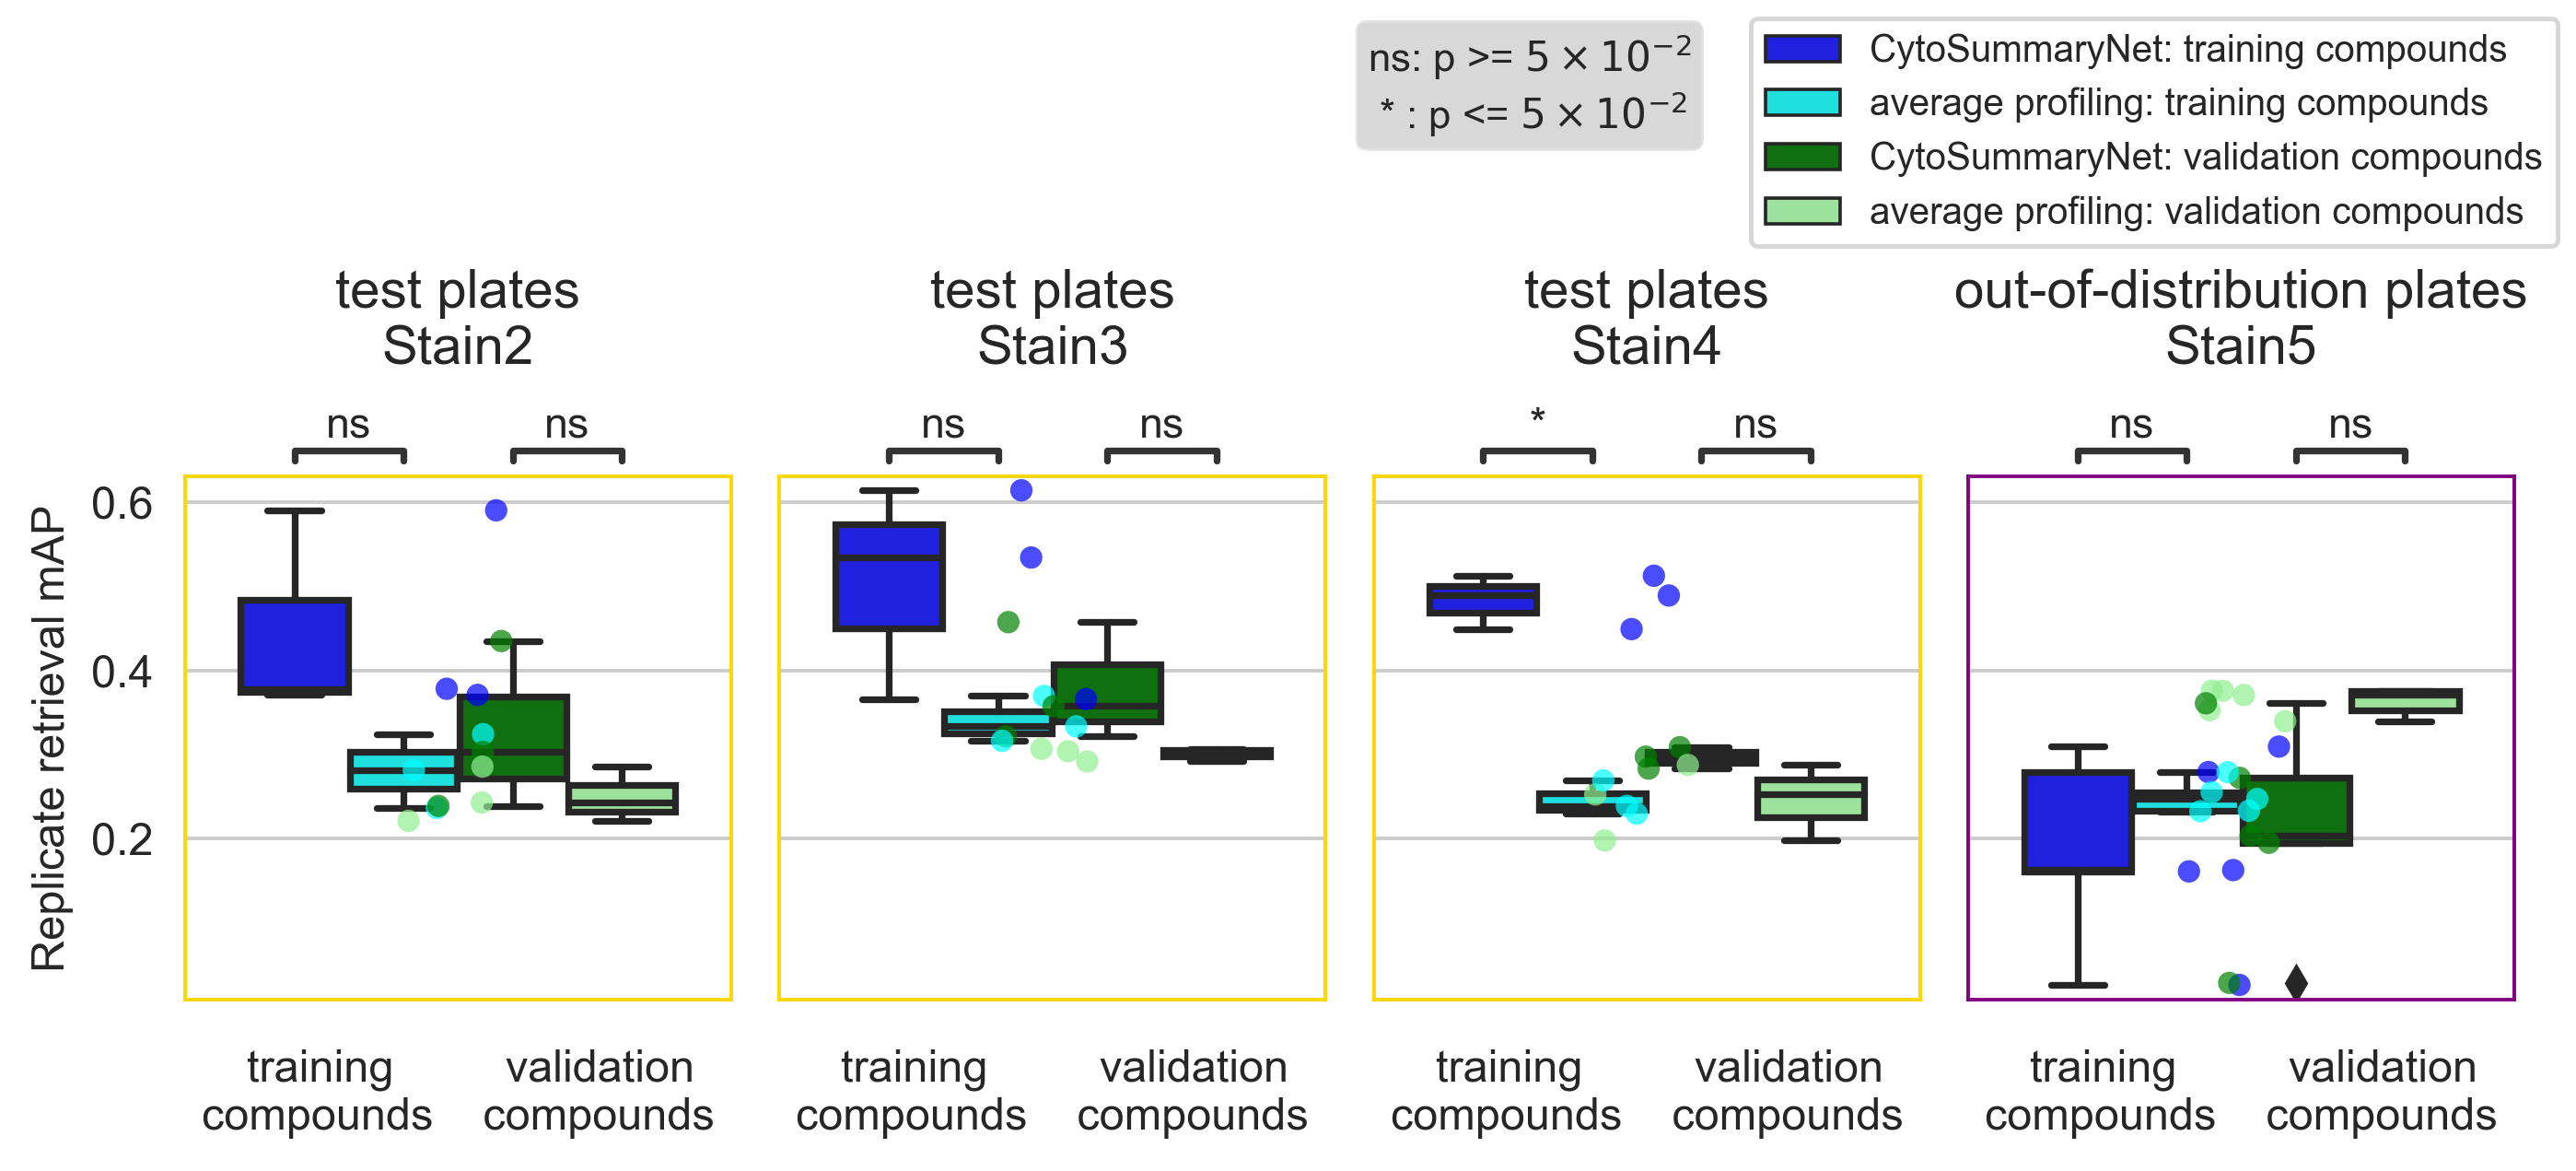

In [73]:
sns.set_style("whitegrid")

x = "dataset"
y = "Training mAP model"
hue = "method"
display_method = 'star' # star full simple


my_pal = {"CytoSummaryNet: validation compounds":"green", "average profiling: validation compounds": 'lightgreen'}
if not only_validation_compounds:
    my_pal['CytoSummaryNet: training compounds'] = "b"
    my_pal['average profiling: training compounds'] = "cyan"
    
if single_dataset:
    fig, ax = plt.subplots(1, 3, dpi=350, figsize=(8, 3))
elif test_plates_only:
    fig, ax = plt.subplots(1, stratY, dpi=350, figsize=(8, 3))
else:
    fig, ax = plt.subplots(3, stratY, dpi=350, figsize=(8, 6))
labels=None
# First loop over different datasets 
for dataset_idx in range(stratY):
    cdataset = datasets[dataset_idx]
    subDF = bigDF.loc[bigDF['dataset'] == cdataset]
    # Then over different stratifications 
    for strat_idx in range(3):
        if not single_dataset and not test_plates_only:
            if dataset_idx==stratY-1 and strat_idx<2:
                continue
        if test_plates_only and strat_idx > 0:
            continue
        subsubDF = subDF.loc[subDF['platelabel'] == stratifications[strat_idx]]
        #print(np.mean(np.array(subsubDF['mAP CytoSummaryNet'][subsubDF.method == 'CytoSummaryNet']-np.array(subsubDF['mAP CytoSummaryNet'][subsubDF.method == 'baseline'])))/np.mean(subsubDF['mAP CytoSummaryNet'][subsubDF.method == 'baseline']))
        # print(subsubDF)
        
        with sns.plotting_context("notebook", font_scale = 0.8):
            if single_dataset:
                current_ax = ax[strat_idx]
            elif test_plates_only:
                current_ax = ax[dataset_idx]
            else:
                current_ax = ax[strat_idx, dataset_idx]
            subax = sns.boxplot(data=subsubDF, x=x, y=y, hue=hue, ax=current_ax, palette=my_pal)
            
            
            subax.set_ylim(min_y, max_y)
            
    
            if labels is None:
                handles, labels = subax.get_legend_handles_labels()
            sns.stripplot(data=subsubDF, x=x, y=y, hue=hue, ax=current_ax, palette=my_pal, alpha=0.7)
            if not only_validation_compounds:
                box_pairs=[((cdataset, 'CytoSummaryNet: training compounds'), (cdataset, 'average profiling: training compounds')), 
                       ((cdataset, 'CytoSummaryNet: validation compounds'), (cdataset, 'average profiling: validation compounds'))]
            else:
                 box_pairs=[((cdataset, 'CytoSummaryNet: validation compounds'), (cdataset, 'average profiling: validation compounds'))]
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                annotator = Annotator(subax, pairs=box_pairs, data=subsubDF, x=x, y=y, hue=hue)
                annotator.configure(test='t-test_welch', text_format=display_method, 
                                    loc='outside', test_short_name='t-test welch', verbose=False)
                annotator.apply_and_annotate()

            # remove all the labels and ticks 
            if strat_idx != 2:
                subax.set(xticklabels=[])
            subax.set(xlabel=None)
            subax.set(xticklabels=[])
            
            subax.tick_params(bottom=False)
            if dataset_idx != 0:
                subax.set(ylabel=None)
            else:
                if strat_idx==0 and test_plates_only:
                    subax.set(ylabel='Replicate retrieval mAP')
                elif strat_idx==0:
                    subax.set_title("training plates", pad=25)
                    subax.set(ylabel='Replicate retrieval mAP')
                elif strat_idx==1:
                    subax.set_title("validation plates", pad=25)
                    subax.set(ylabel='')
                else:
                    subax.set_title("test plates", pad=25)
                    subax.set(ylabel='')
            subax.legend([],[], frameon=False)
            subax.yaxis.set_major_locator(plt.MaxNLocator(4))

fig.subplots_adjust(hspace=0.2, wspace=0.4)
if not merge_datasets:
    if not single_dataset and not test_plates_only:
        fig.delaxes(ax[0][3])
        fig.delaxes(ax[1][3])
    else:
        pass
else:
    fig.delaxes(ax[0][1])
    fig.delaxes(ax[1][1])

fig.legend(handles, labels, loc='upper right', fontsize=8.3)

textstring = r'ns: p >= $5\times10^{-2}$'+'\n'+r' * : p <= $5\times10^{-2}$'
#+'\n**: $10^{-3}$ < p <= $10^{-2}$\n***: $10^{-4}$ < p <= $10^{-3}$\n****: p <= $10^{-4}$
props = dict(boxstyle='round', facecolor='grey', alpha=0.3)
if test_plates_only:
    fig.text(-1.10, 1.85, textstring,
             fontsize=9, transform=subax.transAxes,
            verticalalignment='top', bbox=props)
elif single_dataset:
    fig.text(-0.53, 1.4, textstring,
         fontsize=9, transform=subax.transAxes,
        verticalalignment='top', bbox=props)
else:
    fig.text(-0.12, 3, textstring,
         fontsize=9, transform=subax.transAxes,
        verticalalignment='top', bbox=props)

# Get the minimum and maximum y-axis values across all subplots
min_y = min(a.get_ylim()[0] for a in ax.flatten())
max_y = max(a.get_ylim()[1] for a in ax.flatten())

# Set the y-axis limits to be the same across all subplots
for i, a in enumerate(ax.flatten()):
    #a.set_title(f"{datasets[i]}", pad=20)
    if i != 0:
        a.set(yticklabels=[])

# Set colours
for a in ax.flat[:3]:
    for spine in a.spines.values():
        spine.set_edgecolor('gold')
for spine in ax.flat[-1].spines.values():
    spine.set_edgecolor('purple')

titles = ["test plates\nStain2", "test plates\nStain3", "test plates\nStain4", "out-of-distribution plates\nStain5"]
x_labels = ["  training         validation\ncompounds    compounds"]*4


for a, title, label in zip(ax.flat, titles, x_labels):
    a.set_title(title, pad=25)
    a.set_xlabel(label)

plt.tight_layout()
    
if not merge_datasets:
    plt.savefig(os.path.join(root_dir_model, 'ReplicatemAP.png'), bbox_inches='tight')
else:
    plt.savefig(os.path.join(root_dir_model, 'ReplicatemAP_merged.png'), bbox_inches='tight')
